# HNN-Based Energy-Guiding MPC

This notebook demonstrates an energy-based Model Predictive Control (MPC) approach using a Hamiltonian Neural Network (HNN) as a surrogate model for the system dynamics. The goal is to control a mechanical oscillator by minimizing a quadratic cost while regulating its energy toward a desired target.

The workflow includes:

- Loading of neural network dynamics model (HNN structure),

- Implementation of a differentiable Runge-Kutta integrator for prediction,

- Formulation of the MPC problem using Sequential Quadratic Programming (SQP),

- Closed-loop simulation comparing true dynamics with HNN-based predictions,

- Visualization of trajectories and control performance.

This approach highlights the potential of neural network surrogate models, particularly HNNs, in learning physics-consistent dynamics and embedding them into real-time control frameworks.

In [1]:
# %% Imports
from functools import partial

import equinox as eqx
import jax
import jax.numpy as jnp
import klax
import matplotlib.pyplot as plt
from dynax import ISPHS, LyapunovNN, ODESolver
from jax import random as jr
from jaxopt import BoxOSQP
from jaxtyping import Array
from tqdm.auto import trange

jax.config.update("jax_enable_x64", False)

In [2]:
## Parameters

# MPC horizon: how many future steps to optimize over
horizon = 20

# Time step size for integration
dt = 0.01

# Initial state of the system (4D state vector initialized to zero)
x0 = jnp.zeros(4)

# Desired target energy level (for energy regulation objective)
H_desired = 0.025

# Total simulation time
t_final = 2

# Total number of integration steps for the simulation
N_steps = int(t_final / dt)

# Initial guess for control input trajectory (warm start for optimizer)
u_init = 0.01 * jnp.ones((horizon, 1))  

# MPC cost weights:
# Q: weight on state deviation from target
Q = 1e4

# R: weight on control effort (penalizes large inputs)
R = 0.1

# Number of outer optimization iterations for the SQP solver
iter_outer = 10

# Small regularization term for numerical stability
eps_reg = 1e-6

# State constraints (upper/lower bounds for each state dimension)
x_bound = jnp.array([0.2, 0.2, 0.3, 0.3])

# Control input saturation limit (absolute bound)
u_bound = 2.0


In [3]:
def get_deriv_nn_model():
    # Size of the state vector (4 states for the oscillator system)
    state_size = 4

    # Initialize random keys for reproducibility (JAX-style random number generation)
    key = jr.key(0)
    key_ficnn, key_poisson, key_resistive, key_input = jr.split(key, 4)

    # Define a fully input convex neural network (FICNN) to model the scalar Hamiltonian
    ficnn = klax.nn.FICNN(
        in_size=state_size,      # input: state vector
        out_size="scalar",       # output: scalar Hamiltonian value
        width_sizes=[16, 16],    # hidden layers with 16 neurons each
        key=key_ficnn,
    )

    # Wrap FICNN in a LyapunovNN object to interpret output as a valid Hamiltonian
    hamiltonian = LyapunovNN(ficnn, state_size=state_size, key=key_ficnn)

    # Learnable skew-symmetric matrix representing energy-conserving dynamics (structure matrix)
    poisson_matrix = klax.nn.ConstantSkewSymmetricMatrix(state_size, key=key_poisson)

    # Learnable symmetric positive-definite matrix representing dissipative effects (damping)
    resistive_matrix = klax.nn.ConstantSPDMatrix(
        state_size, epsilon=0.0, key=key_resistive
    )

    # Learnable constant matrix defining how control input enters the system
    input_matrix = klax.nn.ConstantMatrix((state_size, 1), key=key_input)

    # Combine all components into an ISPHS model (Input-State Port-Hamiltonian System)
    deriv_model = ISPHS(hamiltonian, poisson_matrix, resistive_matrix, input_matrix)

    # Attempt to load pretrained weights for the model
    try:
        deriv_model = eqx.tree_deserialise_leaves(
            "two_mass_oscillator_model.eqx", deriv_model
        )
    except FileNotFoundError as e:
        raise RuntimeError("Missing model file: two_mass_oscillator_model.eqx") from e

    # Finalize the model (e.g., freeze constants, compile structure)
    finalized_model = klax.finalize(deriv_model)

    # JIT-compile the model for efficient evaluation
    jitted_model = eqx.filter_jit(finalized_model)

    # Additional helper: JIT-compiled Hamiltonian function for direct energy evaluation
    hami_fun = jax.jit(lambda x: finalized_model.hamiltonian(x))

    # Return both the dynamics model and the Hamiltonian function
    return jitted_model, hami_fun


In [4]:
class Derivative(eqx.Module):
    """
    Derivative of a linear two-mass oscillator system with force input u on mass 2.
    """

    A: Array
    B: Array

    def __init__(
        self, m1: float, m2: float, k1: float, k2: float, d1: float, d2: float
    ):
        inv_m = jnp.diag(1.0 / jnp.array([m1, m2]))
        zeros = jnp.zeros((2, 2))

        # Structure matrix J
        J = jnp.block([[zeros, inv_m], [-inv_m, zeros]])

        # Dissipation matrix R
        dmat = jnp.array(
            [[(d1 + d2) / m1**2, -d2 / (m1 * m2)], [-d2 / (m1 * m2), d2 / m2**2]]
        )
        R = jnp.block([[zeros, zeros], [zeros, dmat]])

        # Hamiltonian matrix Q
        Q = jnp.array(
            [[k1 + k2, -k2, 0, 0], [-k2, k2, 0, 0], [0, 0, m1, 0], [0, 0, 0, m2]]
        )

        self.A = (J - R) @ Q
        self.B = jnp.array([[0], [0], [0], [1 / m2]])

    def __call__(self, t: float, x: Array, u: Array) -> Array:
        return self.A @ x + self.B @ u


In [5]:
def make_rk4_step(f):
    """Create a single-step RK4 integrator for dynamics f(t, x, u)."""

    @jax.jit  # JIT-compile for speed
    def _rk4_step(dt, x, u, t=0.0):
        # Classical 4th-order Runge-Kutta integration scheme
        k1 = f(t, x, u)
        k2 = f(t + 0.5 * dt, x + 0.5 * dt * k1, u)
        k3 = f(t + 0.5 * dt, x + 0.5 * dt * k2, u)
        k4 = f(t + dt, x + dt * k3, u)

        # Weighted average of slopes to compute next state
        return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

    return _rk4_step


# Instantiate the neural network dynamics model and energy function
dynamics, energy_fn = get_deriv_nn_model()

# Create an RK4 integration step specifically for the NN dynamics
rk4_step_nn = make_rk4_step(dynamics)


def rollout(x0, us, dt, solver_step):
    """Simulate trajectory starting from x0 with control sequence us."""
    
    def body(x, u):
        # Compute next state using provided solver step (e.g., rk4_step_nn)
        x_next = solver_step(dt, x, u)
        return x_next, x_next  # Updated carry and output for lax.scan

    # Use JAX's efficient scan to iteratively apply solver over control sequence
    _, trajectory = jax.lax.scan(body, x0, us)
    return trajectory


# JIT-compiled rollout function using neural network RK4 integrator
rollout_jit = jax.jit(
    lambda x0, us, dt: rollout(x0, us, dt, rk4_step_nn),
    static_argnums=(2,)  # Treat `dt` as a static argument for compilation
)

In [6]:
# Default solver settings
DEFAULT_ITERS = 400         # Max iterations for QP solver
DEFAULT_RHO = 1e-3          # Initial penalty parameter for OSQP solver

def matvec_A(A_eq, z):
    """Augmented system matrix-vector multiplication.
    
    For BoxOSQP, this defines a linear operator combining:
    - An identity block (for box constraints)
    - The equality constraint matrix A_eq
    """
    return jnp.concatenate([z, A_eq @ z])

# Preconfigured solver instance:
# BoxOSQP is a custom QP solver for problems with box and equality constraints.
BOX_SOLVER = BoxOSQP(
    matvec_A=matvec_A,        # Defines structure of constraints
    rho_start=DEFAULT_RHO,    # Initial penalty parameter
    maxiter=DEFAULT_ITERS,    # Max solver iterations
    tol=1e-8                  # Convergence tolerance
)

@partial(jax.jit, static_argnames=("solver",))
def solve_qp(H, g, A_eq, b_eq, l_box, u_box, *, solver=BOX_SOLVER):
    """Solve a Quadratic Program (QP) with box constraints and equality constraints using BoxOSQP.
    
    Minimize: 0.5 * z^T H z + g^T z
    subject to:
        l_box ≤ z ≤ u_box (box constraints)
        A_eq z = b_eq (affine equality constraints)
    """

    # Concatenate box bounds with equality constraints in a unified form
    l_total = jnp.concatenate([l_box, b_eq])
    u_total = jnp.concatenate([u_box, b_eq])

    # Call solver to compute optimal solution
    sol, _ = solver.run(
        init_params=None,           # No warm-start
        params_obj=(H, g),          # Quadratic cost terms
        params_eq=A_eq,             # Equality constraints
        params_ineq=(l_total, u_total),  # Box bounds and equality targets
    )

    # Extract and return flattened primal solution
    x_opt = sol.primal[0]
    return jnp.ravel(x_opt)


In [7]:
@jax.jit
def Fx(x, u):
    # Compute Jacobian of f(x, u) w.r.t. x using automatic differentiation
    def f_x(x_):
        return rk4_step_nn(dt, x_, u)
    return jax.jacrev(f_x)(x)

@jax.jit
def Fu(x, u):
    # Compute Jacobian of f(x, u) w.r.t. u using automatic differentiation
    def f_u(u_):
        return rk4_step_nn(dt, x, u_)
    return jax.jacrev(f_u)(u)

def mpc_control_sqp(
    x0, H_ref, u_init=None, *,
    horizon=20, dt=1e-2,
    Q=1e4, R=1e-1,
    x_min=-jnp.array([0.2, 0.2, 0.3, 0.3]),
    x_max=jnp.array([0.2, 0.2, 0.3, 0.3]),
    u_min=-1.0, u_max=1.0,
    max_outer=10, reg=1e-6
):
    """
    Sequential Quadratic Programming (SQP)-based MPC:
    - Hard box constraints on state and control.
    - Linearized dynamics around current trajectory.
    - Energy regulation objective.

    Returns:
    - u0: first control to apply
    - u_seq: optimized sequence
    """

    m = 1          # input dimension
    n = x0.size    # state dimension

    # --- Helpers for restructuring decision variables
    def delta_to_sequences(delta):
        deltax = delta[:n * horizon].reshape(horizon, n)
        detlau = delta[n * horizon:].reshape(horizon, m)
        return deltax, detlau

    def max_violation(x_seq, u_seq, x_min, x_max, u_min, u_max):
        """Max violation (∞-norm) of state and control constraints."""
        v = 0.0
        v = jnp.maximum(v, jnp.max(jnp.maximum(0, x_min - x_seq)))
        v = jnp.maximum(v, jnp.max(jnp.maximum(0, x_seq - x_max)))
        v = jnp.maximum(v, jnp.max(jnp.maximum(0, u_min - u_seq)))
        v = jnp.maximum(v, jnp.max(jnp.maximum(0, u_seq - u_max)))
        return v

    def merit(x_seq, u_seq, mu=10.0):
        """Merit function = objective + μ * constraint violations."""
        e = jax.vmap(energy_fn)(x_seq[:-1]) - H_ref
        cost = Q * jnp.sum(e**2) + R * jnp.sum(u_seq**2)
        viol = max_violation(x_seq, u_seq, x_min, x_max, u_min, u_max)
        return cost + mu * viol

    def propagate_delta_x(delta_x0, delta_u, A_seq, B_seq):
        """Forward simulate the linearized system for deltas."""
        deltax = []
        dx = delta_x0
        for Ak, Bk, du in zip(A_seq, B_seq, delta_u):
            dx = Ak @ dx + Bk @ du
            deltax.append(dx)
        return jnp.stack(deltax)

    # --- Initialization
    u_seq = jnp.zeros((horizon, m)) if u_init is None else u_init
    u_seq = jnp.clip(u_seq, u_min, u_max)
    x_roll = rollout_jit(x0, u_seq, dt)
    x_seq = jnp.vstack([x0, x_roll])

    # Estimate initial penalty parameter μ based on energy and effort scales
    e = jax.vmap(energy_fn)(x_seq[:-1]) - H_ref
    e_eff_max = max(Q * jnp.sum(e**2) / e.shape[0], R * jnp.sum(u_seq**2) / u_seq.shape[0])
    mu = 20.0 * e_eff_max

    for _ in range(max_outer):
        x_roll = rollout_jit(x0, u_seq, dt)
        x_seq = jnp.vstack([x0, x_roll])

        # Clip state to respect constraints before linearization
        if (x_seq[:-1] < x_min).any() or (x_seq[:-1] > x_max).any():
            x_seq = x_seq.at[:-1].set(jnp.clip(x_seq[:-1], x_min, x_max))

        # --- Linearize dynamics around current trajectory
        A_seq = jax.vmap(Fx)(x_seq[:-1], u_seq)
        B_seq = jax.vmap(Fu)(x_seq[:-1], u_seq)

        # --- Build Gauss-Newton Hessian and gradient for QP
        def stage_terms(x, u):
            e = energy_fn(x) - H_ref
            g_x = 2 * Q * e * jax.grad(energy_fn)(x)
            g_u = 2 * R * u
            Jx = jax.grad(energy_fn)(x)
            H_xx = 2 * Q * jnp.outer(Jx, Jx)
            H_uu = 2 * R * jnp.eye(m)
            return g_x, g_u, H_xx, H_uu

        gxs, gus, Hxxs, Huus = jax.vmap(stage_terms)(x_seq[:-1], u_seq)

        # --- Assemble dense QP
        N = horizon
        dim_z = n * N + m * N
        H = reg * jnp.eye(dim_z)  # regularization
        g = jnp.zeros(dim_z)

        for k in range(N):
            # Add stage Hessians and gradients
            H = H.at[n * k:n * (k + 1), n * k:n * (k + 1)].add(Hxxs[k])
            g = g.at[n * k:n * (k + 1)].add(gxs[k])
            off = n * N + m * k
            H = H.at[off:off + m, off:off + m].add(Huus[k])
            g = g.at[off:off + m].add(gus[k].reshape(-1))

        # --- Equality constraints: linearized dynamics
        Aeq = jnp.zeros((n * N, dim_z))
        beq = jnp.zeros(n * N)
        for k in range(N):
            Aeq = Aeq.at[n*k:n*(k+1), n*k:n*(k+1)].set(jnp.eye(n))
            if k > 0:
                Aeq = Aeq.at[n*k:n*(k+1), n*(k-1):n*k].set(-A_seq[k-1])
            off = n * N + m * k
            Aeq = Aeq.at[n*k:n*(k+1), off:off + m].set(-B_seq[k])
            r_k = rk4_step_nn(dt, x_seq[k], u_seq[k]) - x_seq[k+1]
            beq = beq.at[n*k:n*(k+1)].set(r_k)

        # --- Box constraints on state deviations and inputs
        l_box = jnp.concatenate([(x_min - x_seq[:-1]).reshape(-1), (u_min - u_seq).reshape(-1)])
        u_box = jnp.concatenate([(x_max - x_seq[:-1]).reshape(-1), (u_max - u_seq).reshape(-1)])

        # --- Solve QP
        deltaz = solve_qp(H, g, Aeq, beq, l_box, u_box)
        _, deltau = delta_to_sequences(deltaz)

        # Line search on merit function and feasibility check
        alpha = 1.0
        merit_prev = merit(x_seq, u_seq, mu)
        u_new = u_seq
        step_ok = False

        for _ in range(8):
            u_try = jnp.clip(u_seq + alpha * deltau, u_min, u_max)
            detlau_clip = u_try - u_seq
            detlax_lin = propagate_delta_x(jnp.zeros(n), detlau_clip, A_seq, B_seq)
            x_try_lin = x_seq[:-1] + detlax_lin
            m_try = merit(jnp.vstack([x0, x_try_lin]), u_try, mu)

            # True rollout for feasibility check
            x_roll_try = rollout_jit(x0, u_try, dt)
            x_try = jnp.vstack([x0, x_roll_try])
            viol_try = max_violation(x_try, u_try, x_min, x_max, u_min, u_max)

            if (m_try < merit_prev) and (viol_try <= 1e-8):
                u_new = u_try
                step_ok = True
                break
            alpha *= 0.5

        if step_ok:
            merit_prev = m_try
        else:
            u_new = u_seq  # reject step

        x_roll_new = rollout_jit(x0, u_new, dt)
        x_new = jnp.vstack([x0, x_roll_new])

        if alpha < 1.0:
            mu = jnp.clip(mu * 2.0, 10.0, 1e6)

        cost_drop = merit_prev - merit(x_new, u_new, mu)
        viol_now = max_violation(x_new, u_new, x_min, x_max, u_min, u_max)
        if cost_drop < 1e-6 and viol_now < 1e-4:
            u_seq = u_new
            break

        x_seq = x_new
        u_seq = u_new

    return u_seq[0], u_seq


In [8]:
## Single MPC solve test

# Run one instance of MPC solve starting from initial state x0
u0_opt, _ = mpc_control_sqp(
    x0=x0,                  # initial state
    H_ref=H_desired,        # desired energy level
    u_init=u_init,          # warm-start control guess
    horizon=horizon,        # MPC horizon length
    dt=dt,                  # time step
    Q=Q,                    # state/energy tracking weight
    R=R,                    # control effort weight
    x_min=-x_bound,         # lower state bounds
    x_max=x_bound,          # upper state bounds
    u_min=-u_bound,         # control lower bound
    u_max=u_bound,          # control upper bound
    max_outer=iter_outer,   # number of SQP iterations
    reg=eps_reg,            # regularization for Hessian
)

# Report first control computed by MPC (this would be applied to system)
print(f"Single Solve Test for x0 = {x0} returned {u0_opt}")

Single Solve Test for x0 = [0. 0. 0. 0.] returned [2.]


In [9]:
# %% Closed-loop sim

# Define the *true* physical system parameters (two-mass oscillator)
deriv_true = Derivative(m1=1, m2=2, k1=5, k2=2, d1=0.1, d2=0.1)
true_system = eqx.filter_jit(ODESolver(deriv_true))  # JIT-compiled true simulator

def sim_closed_loop(
    x0: jnp.ndarray, u_init: jnp.ndarray, N_steps: int,
    *, H_desired, horizon, dt, Q, R, x_bound, u_bound, iter_outer, eps_reg, true_sys=False
):
    """Run a closed-loop MPC simulation using either:
    - True dynamics (`true_sys=True`), or
    - Learned NN surrogate dynamics (`true_sys=False`).
    """

    x = x0            # Current state
    u_prev = u_init   # Previous input sequence (warm start)
    traj = []         # Store trajectory history
    u_hist = []       # Store input history

    for _ in trange(N_steps):
        # At every step, solve MPC for current state
        u0, u_prev = mpc_control_sqp(
            x0=x,
            H_ref=H_desired,
            u_init=u_prev,        # Warm-start from previous solve
            horizon=horizon,
            dt=dt,
            Q=Q,
            R=R,
            x_min=-x_bound,
            x_max=x_bound,
            u_min=-u_bound,
            u_max=u_bound,
            max_outer=iter_outer,
            reg=eps_reg,
        )

        # Apply u0 to chosen system (true or learned NN)
        if true_sys:
            # Integrate true physical system over one time step [0, dt]
            x = true_system(jnp.array([0.0, dt]), x, jnp.array([u0, u0]))[1]
        else:
            # Integrate learned NN dynamics using RK4 step
            x = rk4_step_nn(dt, x, u0)

        traj.append(x)
        u_hist.append(u0)

    # Return entire trajectory and input history as arrays
    return jnp.stack(traj), jnp.stack(u_hist)

# --- Run closed-loop simulation using learned NN dynamics ---
traj_nn, u_hist_nn = sim_closed_loop(
    x0=x0,
    u_init=u_init,
    N_steps=N_steps,
    H_desired=H_desired,
    horizon=horizon,
    dt=dt,
    Q=Q,
    R=R,
    x_bound=x_bound,
    u_bound=u_bound,
    iter_outer=iter_outer,
    eps_reg=eps_reg,
    true_sys=False,   # Use learned NN model
)

# --- Run closed-loop simulation using true system dynamics ---
traj_true, u_hist_true = sim_closed_loop(
    x0=x0,
    u_init=u_init,
    N_steps=N_steps,
    H_desired=H_desired,
    horizon=horizon,
    dt=dt,
    Q=Q,
    R=R,
    x_bound=x_bound,
    u_bound=u_bound,
    iter_outer=iter_outer,
    eps_reg=eps_reg,
    true_sys=True,    # Use true physical model
)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(<Figure size 1200x800 with 6 Axes>,
 array([[<Axes: ylabel='x1/x2'>, <Axes: ylabel='H'>],
        [<Axes: ylabel='x3/x4'>, <Axes: ylabel='‖x_true − x_nn‖₂'>],
        [<Axes: ylabel='u'>,
         <Axes: xlabel='time [s]', ylabel='|u_nn - u_true|'>]],
       dtype=object))

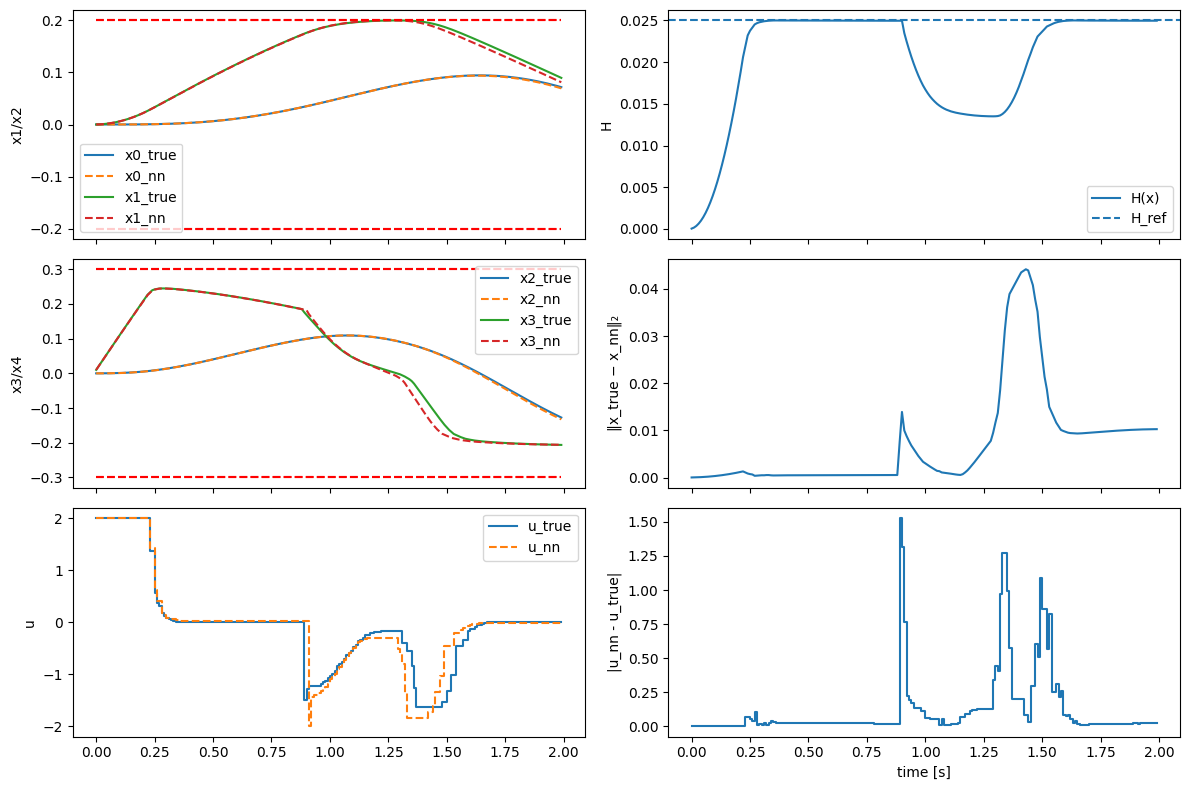

In [10]:
# %% Plotting

def plot_closed_loop_results(
    tgrid, traj_true, traj_nn, u_hist_true, u_hist_nn,
    x_bound, H_desired, energy_fn
):
    """Plot diagnostics comparing true vs. NN closed-loop trajectories."""

    fig, ax = plt.subplots(3, 2, sharex=True, figsize=(12, 8))

    # --- Plot state trajectories x1 and x2
    for i in range(2):
        ax[0, 0].plot(tgrid, traj_true[:, i], label=f"x{i}_true")
        ax[0, 0].plot(tgrid, traj_nn[:, i], label=f"x{i}_nn", linestyle="--")
        ax[0, 0].hlines([x_bound[i], -x_bound[i]], tgrid[0], tgrid[-1],
                        colors="red", linestyles="--")
    ax[0, 0].set_ylabel("x1/x2")
    ax[0, 0].legend()

    # --- Plot state trajectories x3 and x4
    for i in range(2):
        idx = 2 + i
        ax[1, 0].plot(tgrid, traj_true[:, idx], label=f"x{idx}_true")
        ax[1, 0].plot(tgrid, traj_nn[:, idx], label=f"x{idx}_nn", linestyle="--")
        ax[1, 0].hlines([x_bound[idx], -x_bound[idx]], tgrid[0], tgrid[-1],
                        colors="red", linestyles="--")
    ax[1, 0].set_ylabel("x3/x4")
    ax[1, 0].legend()

    # --- Plot control inputs
    ax[2, 0].step(tgrid, u_hist_true.squeeze(), where="post", label="u_true")
    ax[2, 0].step(tgrid, u_hist_nn.squeeze(), where="post", label="u_nn", linestyle="--")
    ax[2, 0].set_ylabel("u")
    ax[2, 0].legend()

    # --- Plot Hamiltonian (energy) trajectory for NN simulation
    H_vals = jax.vmap(energy_fn)(traj_nn)
    ax[0, 1].plot(tgrid, H_vals, label="H(x)")
    ax[0, 1].axhline(H_desired, ls="--", label="H_ref")
    ax[0, 1].set_ylabel("H")
    ax[0, 1].legend()

    # --- Plot trajectory error: ‖x_true − x_nn‖₂
    err_x = jnp.linalg.norm(traj_true - traj_nn, axis=1)
    ax[1, 1].plot(tgrid, err_x)
    ax[1, 1].set_ylabel("‖x_true − x_nn‖₂")

    # --- Plot input difference: |u_true − u_nn|
    err_u = jnp.abs(u_hist_nn - u_hist_true).squeeze()
    ax[2, 1].step(tgrid, err_u, where="post")
    ax[2, 1].set_ylabel("|u_nn - u_true|")
    ax[2, 1].set_xlabel("time [s]")

    fig.tight_layout()
    return fig, ax

# --- Prepare time grid for plotting ---
tgrid = dt * jnp.arange(traj_nn.shape[0])

# --- Generate plots comparing closed-loop trajectories ---
plot_closed_loop_results(
    tgrid,
    traj_true, traj_nn,
    u_hist_true, u_hist_nn,
    x_bound, H_desired,
    energy_fn
)
